In [1]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus
from tqdm import tqdm
from music21 import corpus, metadata, note, stream

def corpus_to_training_data(composer):
    paths = corpus.getComposer(composer)

    all_states = set()
    all_pitches = set()
    all_durations = set()
    training_data = []
    chord_occurence_count = 0
    note_count = 0
    for p in tqdm(paths):
        # Load the score
        s = corpus.parse(p)
        
        soprano_part = None
        for part in s.parts:
            if "Soprano" in (part.partName or ""):  # Check for 'Soprano' in the part name
                soprano_part = part
                break
        
        # Fallback if no explicit Soprano part is named
        if soprano_part is None:
            # Assume the first part is the Soprano if no explicit naming is found
            soprano_part = s.parts[0]
        
        # Extract notes and rests (pitch and duration)
        notes_sequence = []
        for element in soprano_part.flat.notesAndRests:  # Include notes and rests
            if element.isNote:
                notes_sequence.append((element.pitch.nameWithOctave, element.quarterLength))
            elif element.isChord:        
                # If there's a chord, take the highest note (melodic line usually uses the top note)
                #notes_sequence.append((element.highestNote.nameWithOctave, element.quarterLength))
    
                # Get the bass (lowest) note of the chord
                bass_note = element.bass()
                notes_sequence.append((bass_note.nameWithOctave, element.quarterLength))
    
                chord_occurence_count += 1
            elif element.isRest:
                notes_sequence.append(('Rest', element.quarterLength))
    
        notes = []
        for pitch, duration in notes_sequence:    
            all_pitches.add(pitch)
            all_durations.add(duration)
            s = (pitch, duration)
            if pitch == 'Rest':
                notes.append(note.Rest(quarterLength=s[1]))
                #ignore rests for now
                #pass
            else:
                notes.append(note.Note(s[0], quarterLength=s[1]))        
            all_states.add(s)    
        training_data.append(notes)
        note_count += len(notes)

    print(f'note_count: {note_count}\nskipped_chord_occurence_count: {chord_occurence_count}\ntraining_data_examples: {len(training_data)}\nall_states: {len(all_states)}, all_pitches: {len(all_pitches)}')        
    return training_data, list(all_states)

In [2]:
bach_data, bach_states = corpus_to_training_data('bach')

/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead       | 0/433 [00:00<?, ?it/s]
  return self.iter().getElementsByClass(classFilterList)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:23<00:00, 18.46it/s]

note_count: 23338
skipped_chord_occurence_count: 1156
training_data_examples: 433
all_states: 212, all_pitches: 41


In [3]:
mozart_data, mozart_states = corpus_to_training_data('mozart')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.92it/s]

note_count: 7845
skipped_chord_occurence_count: 64
training_data_examples: 16
all_states: 394, all_pitches: 56


In [4]:
chopin_data, chopin_states = corpus_to_training_data('chopin')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]

note_count: 340
skipped_chord_occurence_count: 13
training_data_examples: 1
all_states: 70, all_pitches: 26


In [6]:
state_union = set()
state_union.update(bach_states)
state_union.update(mozart_states)
state_union.update(chopin_states)

len(state_union)

461

In [7]:
%%time
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator

bach_model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(state_union))
bach_model.train(bach_data)

CPU times: user 65 ms, sys: 7 ms, total: 72 ms
Wall time: 73.4 ms


In [8]:
%%time
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator

mozart_model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(state_union))
mozart_model.train(mozart_data)

CPU times: user 31.3 ms, sys: 3.39 ms, total: 34.6 ms
Wall time: 33 ms


In [9]:
%%time
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator

chopin_model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(state_union))
chopin_model.train(chopin_data)

CPU times: user 5.51 ms, sys: 3.84 ms, total: 9.35 ms
Wall time: 5.85 ms


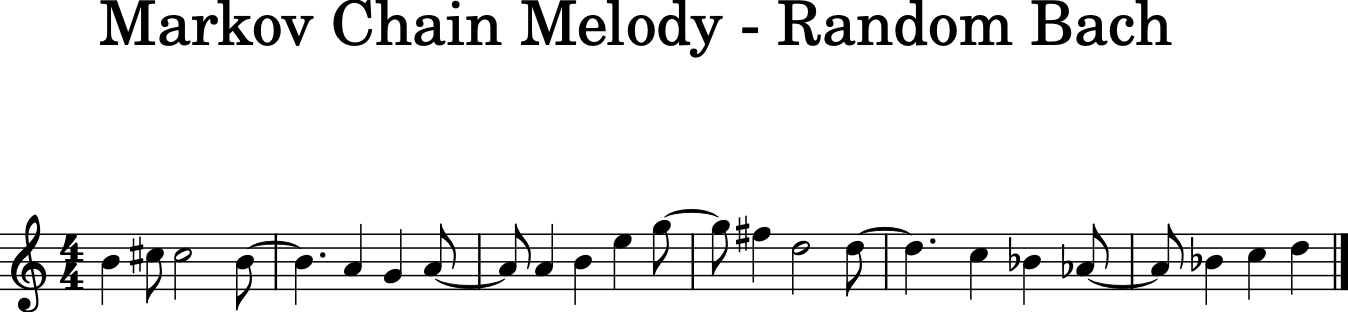

In [20]:
generated_melody, _ = bach_model.generate(20)

from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Random Bach")
part = stream.Part()
for n, d in generated_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()

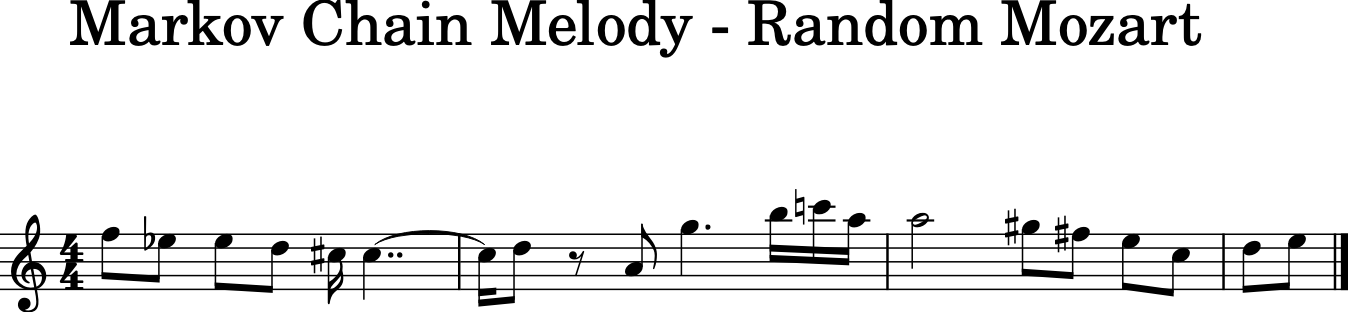

In [11]:
generated_melody, _ = mozart_model.generate(20)

from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Random Mozart")
part = stream.Part()
for n, d in generated_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()

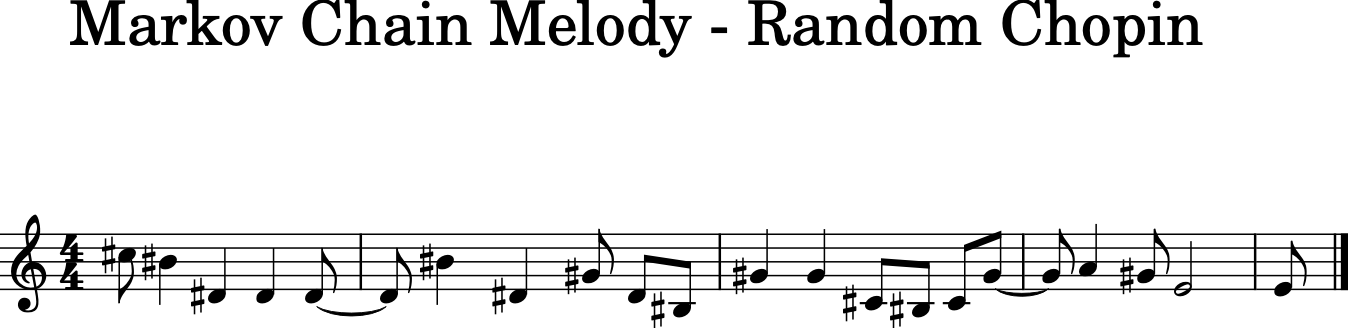

In [13]:
generated_melody, _ = chopin_model.generate(20)

from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Random Chopin")
part = stream.Part()
for n, d in generated_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()

In [14]:
def show_score(melody, title='Markov Chain Melody'):
    score = stream.Score()
    score.metadata = metadata.Metadata(title=title)
    part = stream.Part()
    for n, d in melody:
        if n == 'Rest':
            part.append(note.Rest(quarterLength=d))    
        else:
            part.append(note.Note(n, quarterLength=d))
    score.append(part)
    
    score.show('midi')
    score.show()

In [15]:
# Extend twinkle twinkle

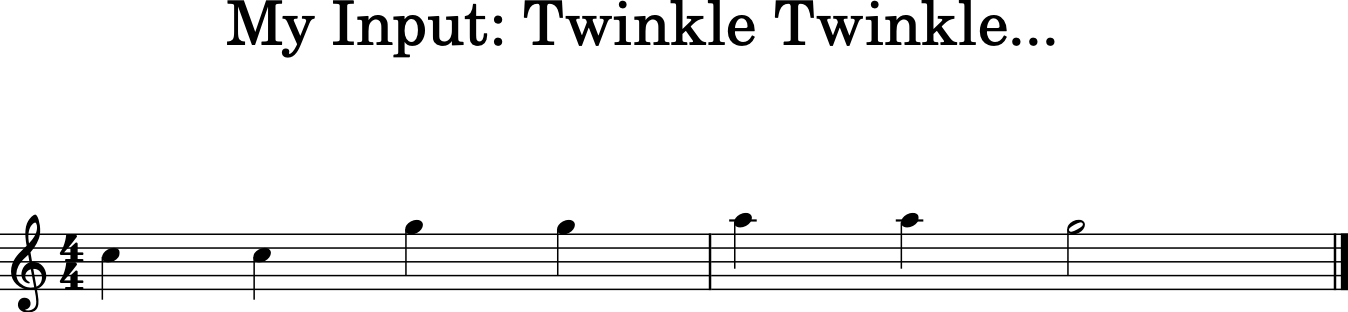

In [16]:
input_melody = [("C5", 1.0), ("C5", 1.0), ("G5", 1.0), ("G5", 1.0), ("A5", 1.0), ("A5", 1.0), ("G5", 2.0)]

show_score(input_melody, 'My Input: Twinkle Twinkle...')

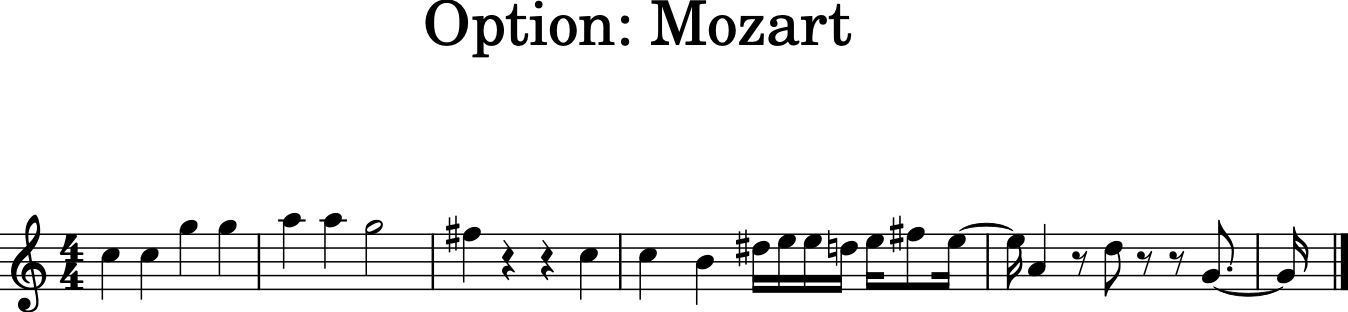

In [21]:
mozart_melody, new_part = mozart_model.generate(20, previous_sequence=input_melody)

show_score(mozart_melody, 'Option: Mozart')

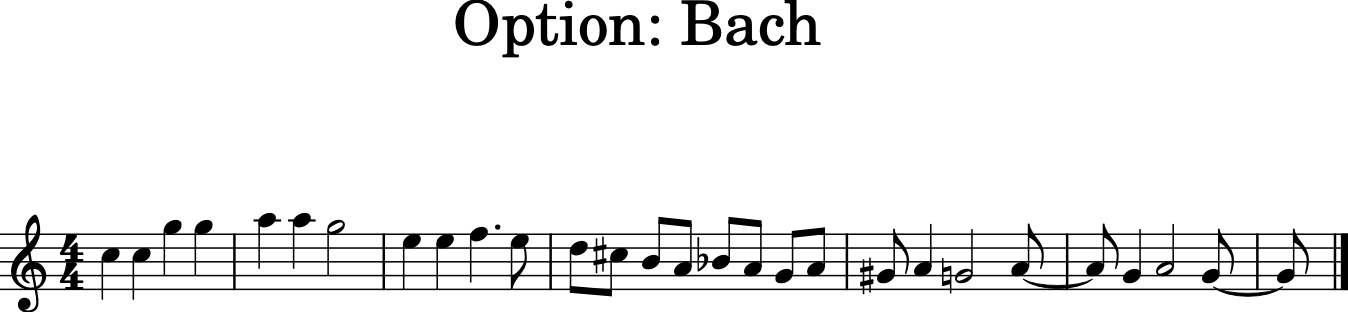

In [22]:
bach_melody, new_part = bach_model.generate(20, previous_sequence=input_melody)

show_score(bach_melody, 'Option: Bach')

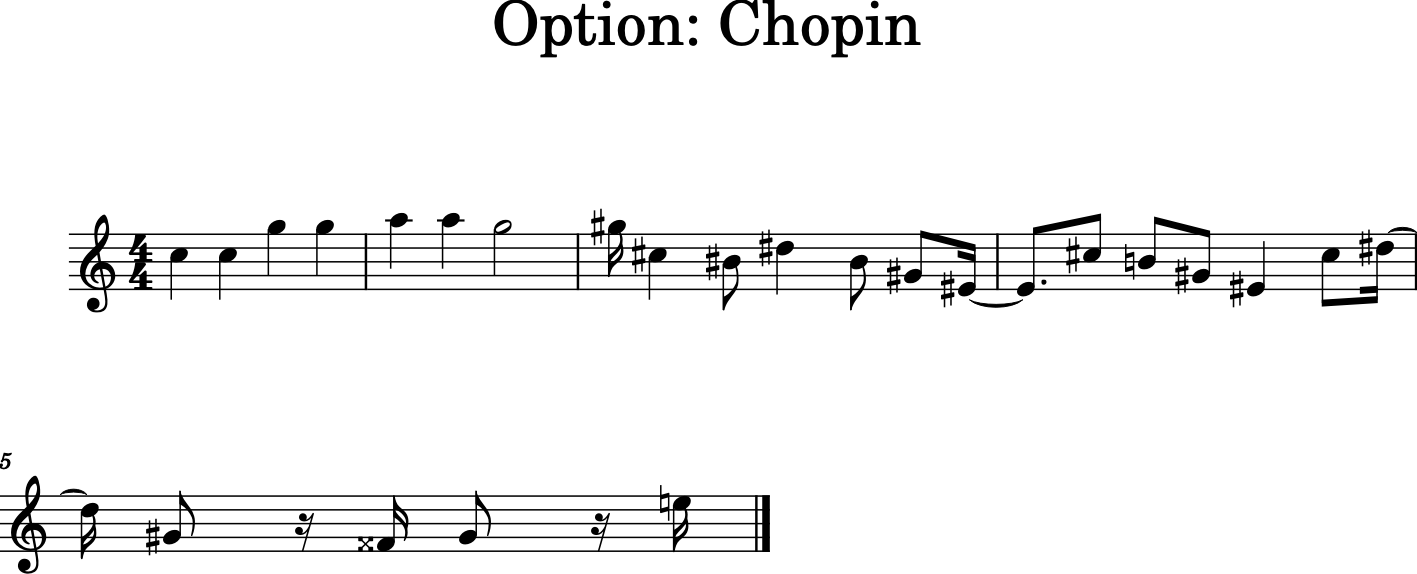

In [23]:
chopin_melody, new_part = chopin_model.generate(20, previous_sequence=input_melody)

show_score(chopin_melody, 'Option: Chopin')

In [25]:
# Continue again , assum picked  bach first

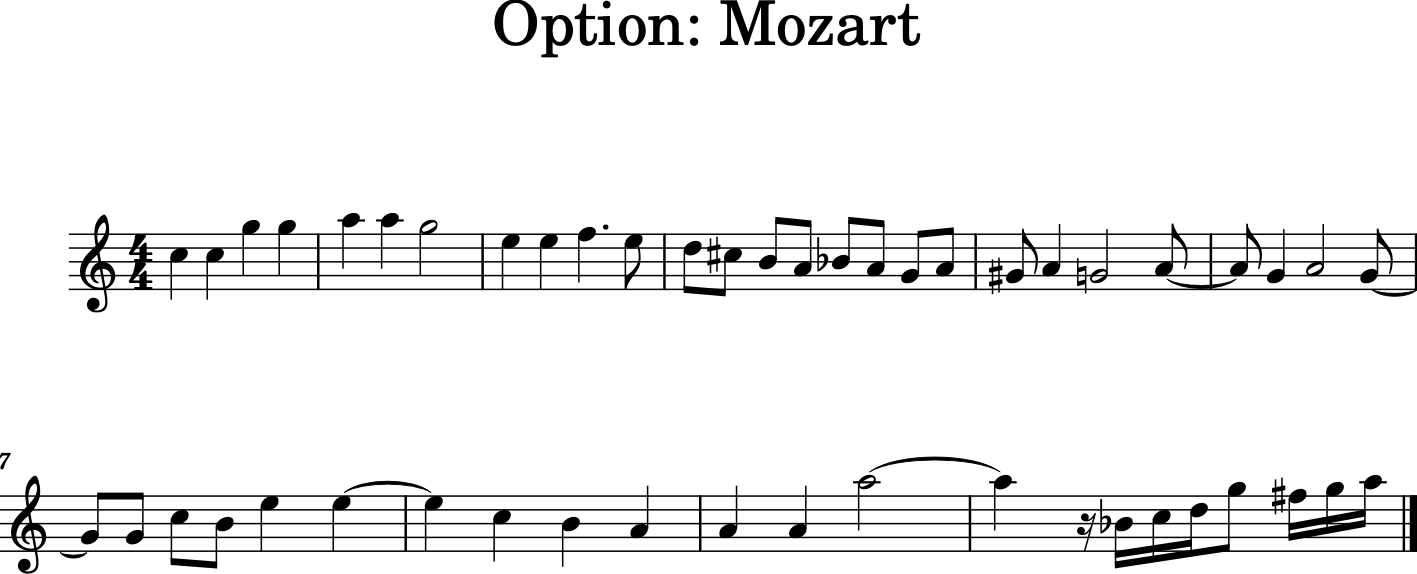

In [26]:
mozart_melody2, new_part = mozart_model.generate(20, previous_sequence=bach_melody)

show_score(mozart_melody2, 'Option: Mozart')

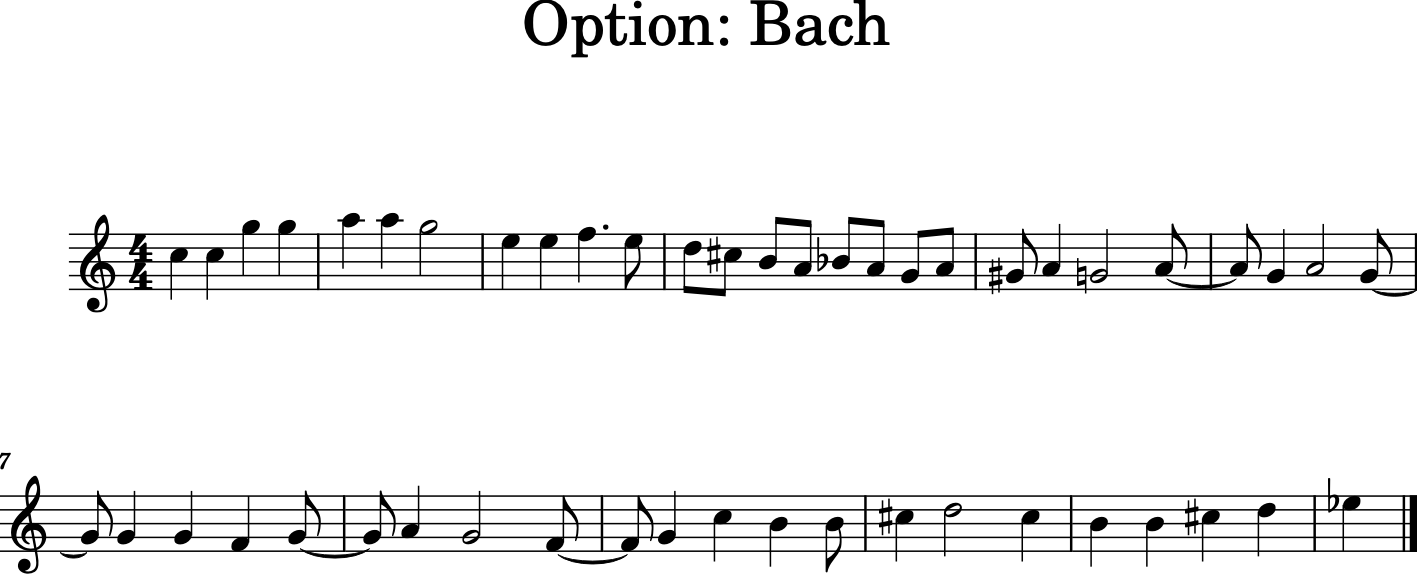

In [27]:
bach_melody2, new_part = bach_model.generate(20, previous_sequence=bach_melody)

show_score(bach_melody2, 'Option: Bach')

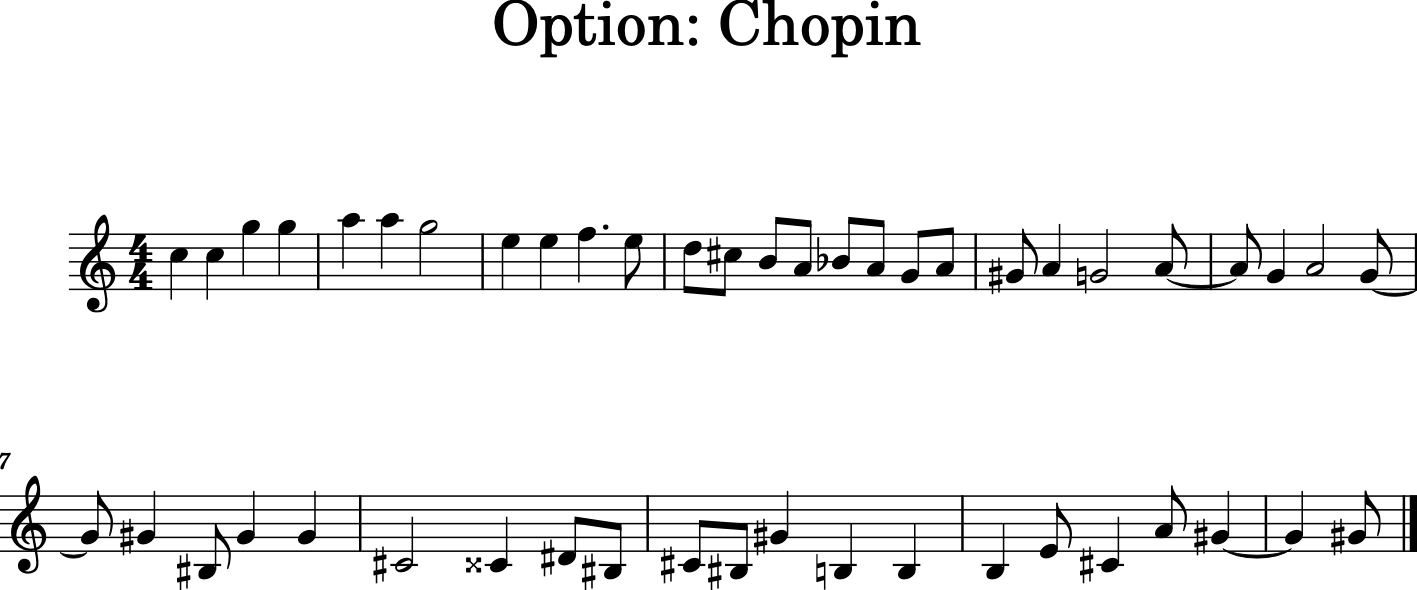

In [28]:
chopin_melody2, new_part = chopin_model.generate(20, previous_sequence=bach_melody)

show_score(chopin_melody2, 'Option: Chopin')